In [1]:
# Import modules
import numpy as np
from qiskit import(
    QuantumCircuit,
    execute,
    Aer,
    QuantumRegister,
    ClassicalRegister
    )

from qiskit.visualization import plot_histogram

In [2]:
# Define our registers and circuit
qb = QuantumRegister(5, 'code_qubit')     # The 5 qubits to encode the state in
an = QuantumRegister(2, 'ancilla_qubit')  # The two ancilla qubits (one of them is unused)
cr = ClassicalRegister(4, 'syndrome_bit') # Classical register for registering the syndromes
readout = ClassicalRegister(5, 'readout') # Readout of the final state at the end for statistics

In [52]:
# Note that some gates might be redundant, haven't checked
def encode_input( circuit, qbReg ):
    '''Encode the input into logical 0 and 1
    This assumes that the 0:th qubit is the
    original state |psi> = a|0> + b|1>'''
    
    circuit.h( qbReg[3] )
    circuit.cz( qbReg[3], qbReg[1] )
    circuit.cz( qbReg[3], qbReg[2] )
    circuit.cx( qbReg[3], qbReg[0] )   

    circuit.h( qbReg[2] )
    circuit.cx( qbReg[2], qbReg[0] )
    circuit.cz( qbReg[2], qbReg[3] )
    circuit.cz( qbReg[2], qbReg[4] )
    
    circuit.h( qbReg[1] )
    circuit.cz( qbReg[1], qbReg[0] )
    circuit.cx( qbReg[1], qbReg[3] )
    circuit.cz( qbReg[1], qbReg[4] )
    
    circuit.h( qbReg[4] )
    circuit.cz( qbReg[4], qbReg[2] )
    circuit.cz( qbReg[4], qbReg[3] )
    circuit.cx( qbReg[4], qbReg[1] )
    
    circuit.barrier( qbReg )
    return

# Define our stabilizers
def measure_stabilizer( circuit, qbReg, anReg, clReg, i ):
    '''Function for adding stabilizer measurements to a circuit.
    Note that a measurement of X is done by using Hadamard before
    and after. Input i specifies the stabilizer to measure:
        i=0: XZZXI
        i=1: IXZZX
        i=2: XIXZZ
        i=3: ZXIXZ
    Other inputs are the circuit as well as the required registers'''
    
    if not isinstance(i, int):
        raise error('i must be an integer')
    
    # Generate indexes
    index = np.mod( i + np.array([0, 1, 2, 3]), 5 ) 
    
    # Measure stabilizers
    circuit.h( qbReg[ index[0] ] )
    circuit.h( anReg[0] )
    circuit.cz( anReg[0], qbReg[ index[0] ] )
    circuit.h( qbReg[ index[0] ] ) 
    
    circuit.cz( anReg[0], qbReg[ index[1] ] )

    circuit.cz( anReg[0], qbReg[ index[2] ] )
        
    circuit.h( qbReg[ index[3] ] )
    circuit.cz( anReg[0], qbReg[ index[3] ] )
    circuit.h( anReg[0] )
    circuit.h( qbReg[ index[3] ] ) 
        
    circuit.measure( anReg[0], clReg[i] )
    circuit.reset( anReg[0] )
    return

def run_stabilizer( circuit, qbReg, anReg, clReg ):
    measure_stabilizer( circuit, qbReg, anReg, clReg, 0 )
    measure_stabilizer( circuit, qbReg, anReg, clReg, 1 )
    measure_stabilizer( circuit, qbReg, anReg, clReg, 2 )
    measure_stabilizer( circuit, qbReg, anReg, clReg, 3 )
    return

# Correct possible errors
def recovery_scheme( circuit, qbReg, clReg ):

    circuit.x(qbReg[1]).c_if(clReg, 1)
    circuit.z(qbReg[4]).c_if(clReg, 2)
    circuit.x(qbReg[2]).c_if(clReg, 3)
    circuit.z(qbReg[2]).c_if(clReg, 4)
    circuit.z(qbReg[0]).c_if(clReg, 5)
    circuit.x(qbReg[3]).c_if(clReg, 6)
    circuit.x(qbReg[2]).c_if(clReg, 7)
    circuit.z(qbReg[2]).c_if(clReg, 7)
    circuit.x(qbReg[0]).c_if(clReg, 8)
    circuit.z(qbReg[3]).c_if(clReg, 9)
    circuit.z(qbReg[1]).c_if(clReg, 10)
    circuit.x(qbReg[1]).c_if(clReg, 11)
    circuit.z(qbReg[1]).c_if(clReg, 11)
    circuit.x(qbReg[4]).c_if(clReg, 12)
    circuit.x(qbReg[0]).c_if(clReg, 13)
    circuit.z(qbReg[0]).c_if(clReg, 13)
    circuit.x(qbReg[4]).c_if(clReg, 14)
    circuit.z(qbReg[4]).c_if(clReg, 14)
    circuit.x(qbReg[3]).c_if(clReg, 15)
    circuit.z(qbReg[3]).c_if(clReg, 15)

    return


{'00000 0000': 58, '10001 0000': 53, '10010 0000': 64, '10100 0000': 69, '10111 0000': 71, '11000 0000': 69, '11011 0000': 52, '11101 0000': 61, '11110 0000': 63, '00011 0000': 67, '00101 0000': 54, '00110 0000': 63, '01001 0000': 72, '01010 0000': 76, '01100 0000': 65, '01111 0000': 67}


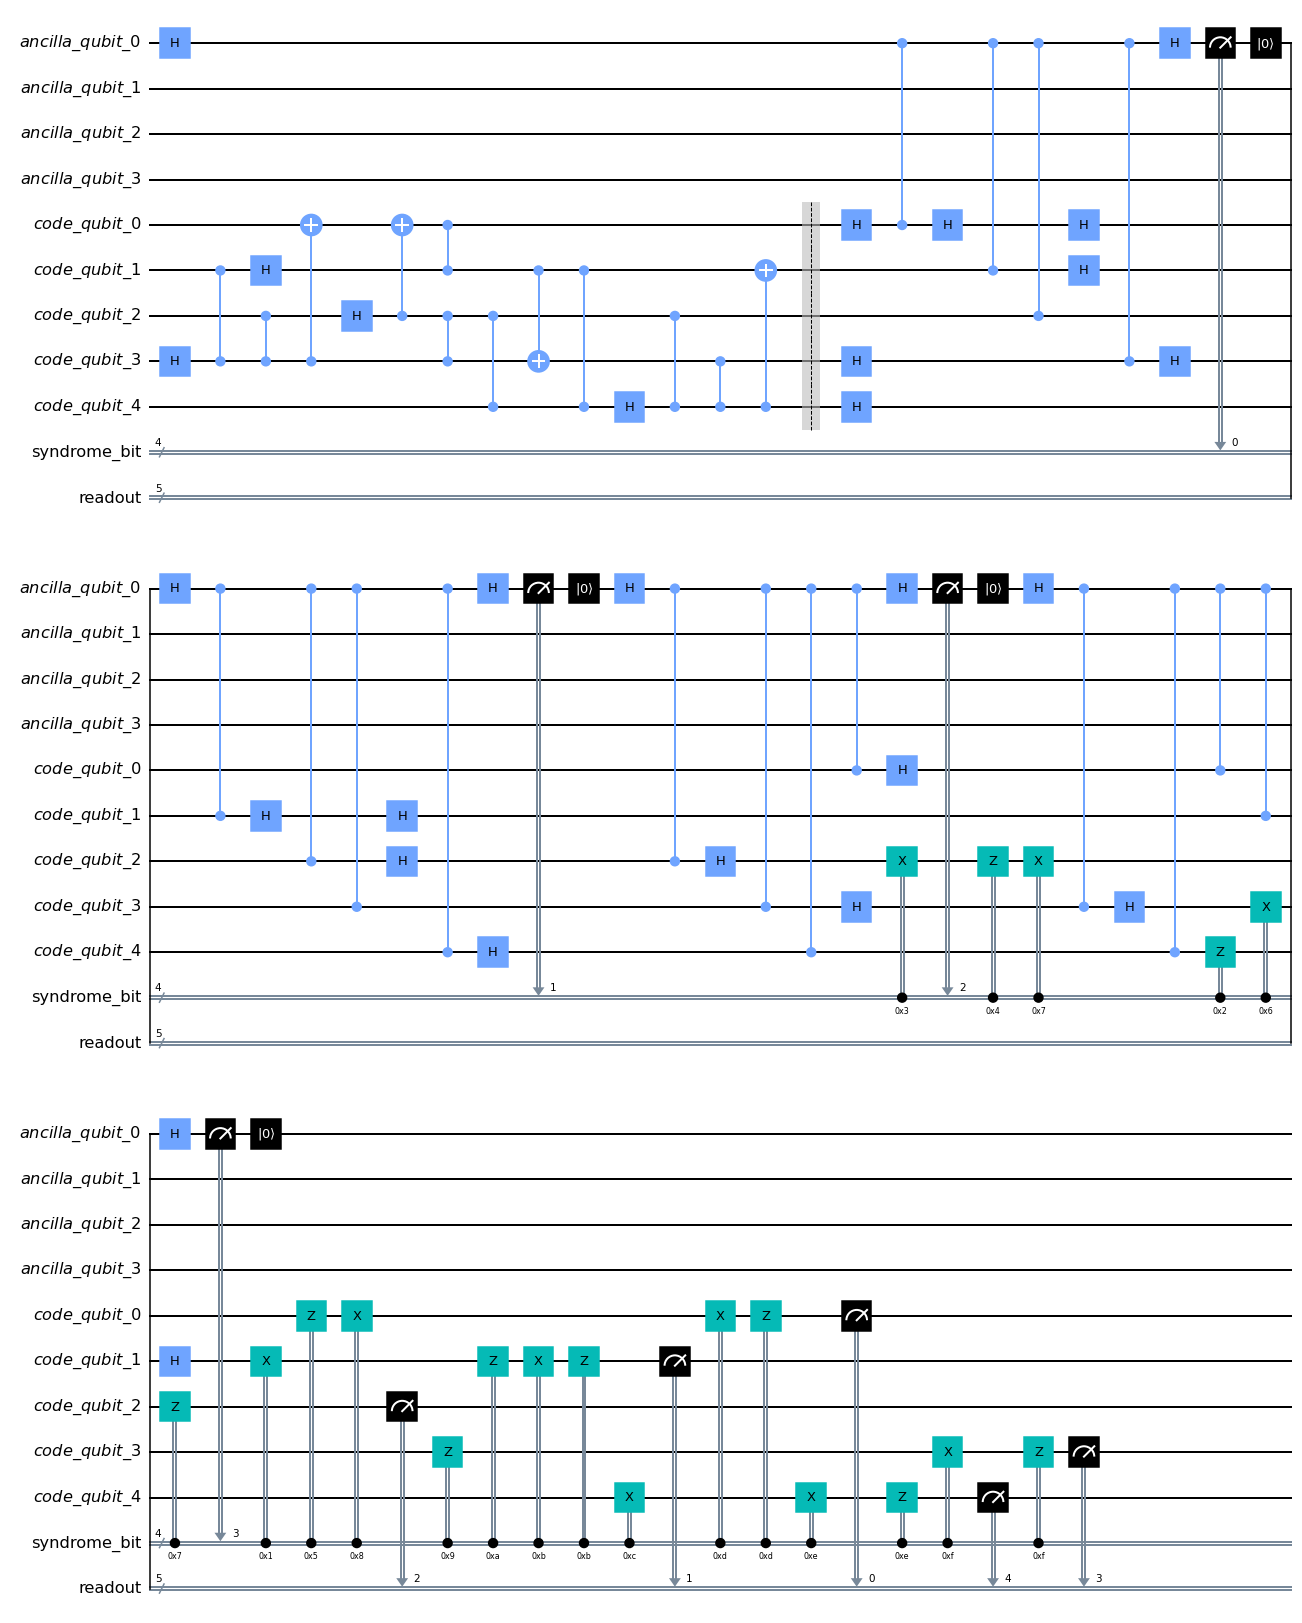

In [53]:
circuit = QuantumCircuit( cr, readout, an, qb )

# Prepare the input
#circuit.x( qb[0] ) # As an example, start in |1>

# Encode the state
encode_input( circuit, qb ) 

# Add errors manually
#circuit.x( qb[3] )
#circuit.z( qb[2] )

# Measure stabilizers
run_stabilizer( circuit, qb, an, cr )

# Correct the error
recovery_scheme( circuit, qb, cr )

#run_stabilizer( circuit, qb, an, cr )
# Readout of the encoded state
circuit.measure( qb, readout )

counts = execute(circuit, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)

circuit.draw(output='mpl') # If it does not work, simply remove mpl: circuit.draw()
#plot_histogram(counts)
